# <center>Machine Learning Workflow

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 1.  Data Exploration

In [2]:
data = pd.read_csv('data/diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Dataset columns

In [3]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

Dataset diamensions

In [4]:
data.shape

(768, 9)

In [5]:
data['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

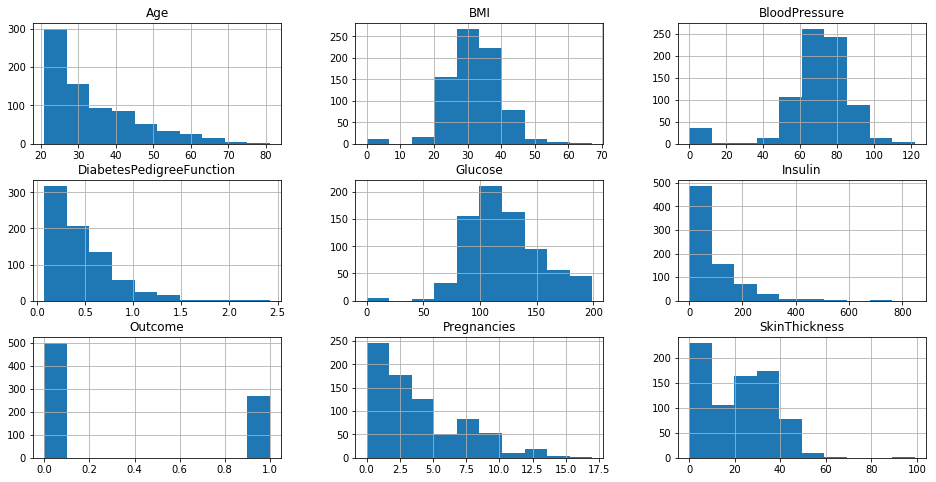

In [6]:
data.hist(figsize=(16,8));

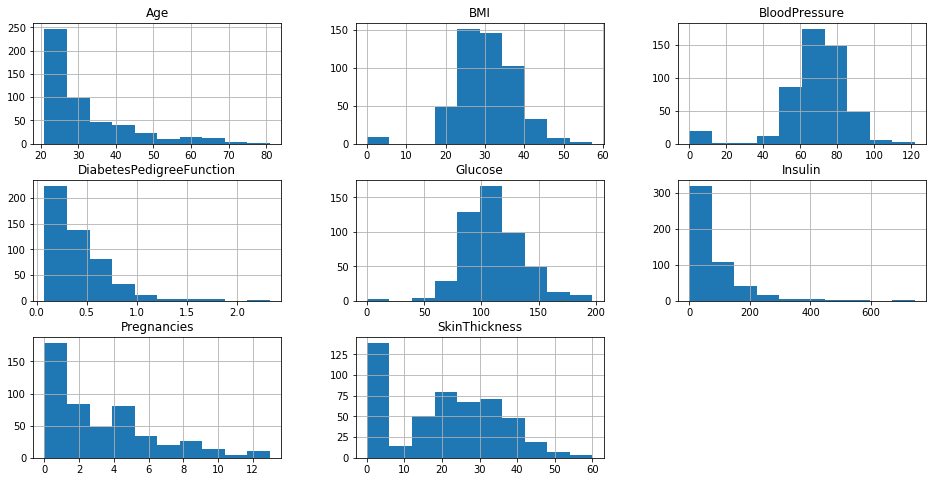

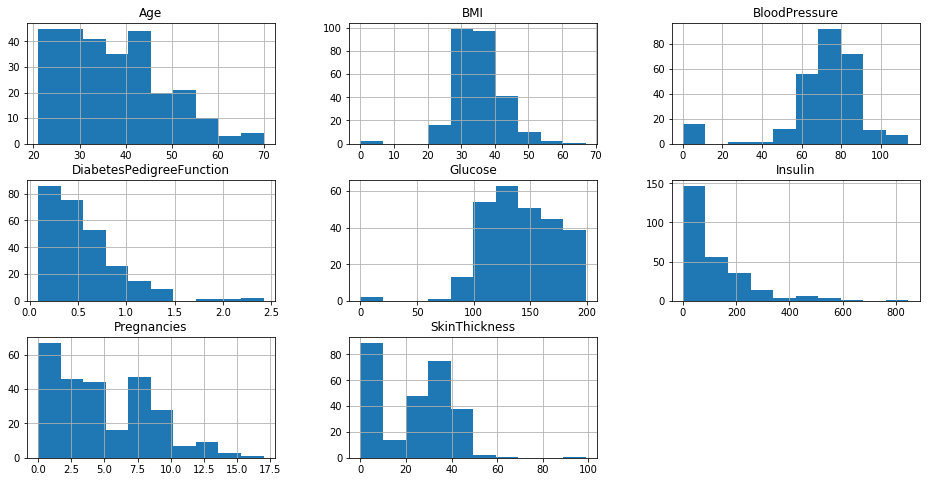

In [7]:
data.groupby('Outcome').hist(figsize=(16,8));

# 2. Data cleaning

In [8]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [9]:
data.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Checking outliers

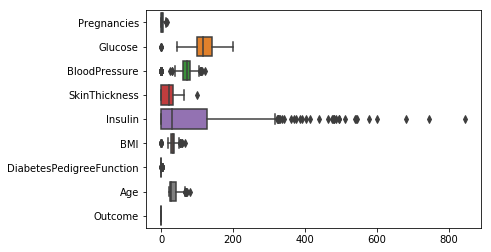

In [10]:
fig, ax = plt.subplots()
sns.boxplot(data=data, orient='h')
plt.show()

Dealing with outliers

In [11]:
Q3, Q1 = np.percentile(data['Insulin'], [75, 25])
iqr = Q3 - Q1
whisker = Q3 + (1.5*iqr)
print('Inter quatile range: ', iqr)
print('Whisker            : ', whisker)

data['Insulin'] = data['Insulin'].clip(upper=whisker)

Inter quatile range:  127.25
Whisker            :  318.125


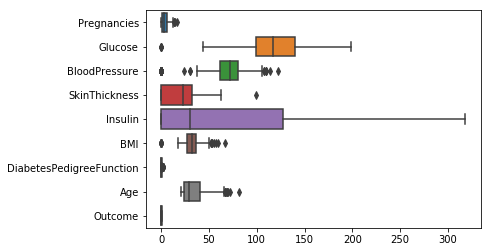

In [12]:
fig, ax = plt.subplots()
sns.boxplot(data=data, orient='h')
plt.show()

# 3. Model selection

In [13]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [14]:
features = ['Pregnancies', 'Glucose', 'BloodPressure', 
            'SkinThickness', 'Insulin','BMI', 
            'DiabetesPedigreeFunction', 'Age']

target = ['Outcome']

x = data[features]
y = data[target]

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score

In [16]:
models = []

models.append(('LR', LogisticRegression(solver='lbfgs', max_iter=4000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier(n_estimators=100)))
models.append(('SVC', SVC(gamma='scale')))
models.append(('GB', GradientBoostingClassifier()))
models.append(('GNB', GaussianNB()))

<center>Using train/test split

<img src='images/train_test.png'>

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.30, random_state=42)

In [18]:
names = []
scores = []

for name, model in models:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    scores.append(accuracy_score(y_test, y_pred))
    names.append(name)

results = pd.DataFrame({'Model': names, 'Accuracy': scores})
results

,Model,Accuracy
0,LR,0.735931
1,KNN,0.696970
2,DT,0.696970
3,RF,0.744589
4,SVC,0.744589
5,GB,0.735931
6,GNB,0.731602


<center>Using K-fold cross validation

<img src='images/k-fold.png'>

In [19]:
folds = StratifiedKFold(n_splits=10, random_state=42)

In [20]:
names = []
scores = []

for name, model in models:
    
    score = cross_val_score(model, x, y, cv=folds, scoring='accuracy').mean()
    names.append(name)
    scores.append(score)

results = pd.DataFrame({'Model': names, 'Accuracy': scores})
results

,Model,Accuracy
0,LR,0.774761
1,KNN,0.727905
2,DT,0.708322
3,RF,0.753845
4,SVC,0.763038
5,GB,0.757826
6,GNB,0.753896


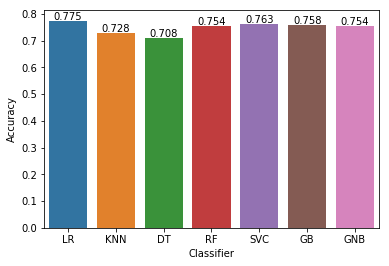

In [21]:
axis = sns.barplot(x ='Model', y ='Accuracy', data = results)
axis.set(xlabel='Classifier', ylabel='Accuracy')

for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.3f}'.format(height), ha="center") 
    
plt.show()

# 4. Feature Selection

Feature selection is actually a part in Feature Engineering in which we analyze how different features affect the model performance. <br>
Scikit Learn provide methods by which we can do feature selection and find out the important features that affect the model. <br>
In this tutorial we will use `Recursive Feature Elimination` (`RFECV`), which recursively remove features and build a model on the remaining features. 

In [22]:
from sklearn.feature_selection import RFECV

We then fit data in to the `RFECV` which have built-in cross validation features.

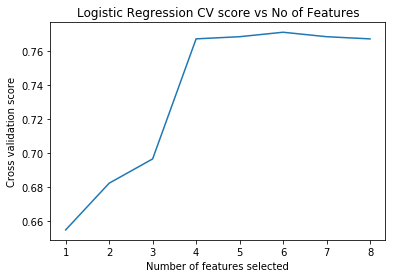

In [23]:
log_reg = LogisticRegression(max_iter=4000)

classifier = RFECV(estimator=log_reg, step=1, cv=folds, scoring='accuracy')
classifier.fit(x, y)

plt.figure()
plt.title('Logistic Regression CV score vs No of Features')
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score')
plt.plot(range(1, len(classifier.grid_scores_) + 1), classifier.grid_scores_)
plt.show()

After fiting data into the model, we can then get the selected features using `grid_scores_` attribute which give the accuracy of each selected feature. After which we can look on the selected  features.

In [24]:
classifier.grid_scores_.tolist()

[0.6549384825700615,
 0.6823308270676691,
 0.6965652768284347,
 0.7669685577580314,
 0.7682330827067669,
 0.7708475734791524,
 0.7682330827067669,
 0.7669514695830486]

In [25]:
feature_importance = list(zip(features, classifier.support_))

keys = []
new_features = []

for key,value in enumerate(feature_importance):
    if(value[1]) == True:
        new_features.append(value[0])
        
print(new_features)

['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age']


We are now set to do a comparison between a model trained on initial features and the one trained on `RFECV` selected features.

In [52]:
X_new = data[new_features]

initial_accuracy = cross_val_score(log_reg, x, y, cv=folds, scoring='accuracy').mean()
print('Accuracy without feature selection: {:.5f} '.format(initial_accuracy))

new_accuracy = cross_val_score(log_reg, X_new, y, cv=folds, scoring='accuracy').mean()
print('Accuracy with feature selection:    {:.5f} '.format(new_accuracy))
diffrence = new_accuracy - initial_accuracy

Accuracy without feature selection: 0.76695 
Accuracy with feature selection:    0.77344 


Notice the slight increase in the accuracy.

# 5. Hyperparameter tuning

Scikit Learn provides Machine Learning Algorithms with default parameters, good enough to give resonable accuracy score. It also provide an option to twist these hyper-parameters to increase the accuracy. <br>
Instead of manually searching for optimum hyper-parameters, we can search using `GridSearchCV` which search over a specified values of of an estimator.

In [53]:
from sklearn.model_selection import GridSearchCV

We then provide a grid with compatible hyper-parameter values to fine tune the model.

In [54]:
c_values = list(np.arange(1, 10))

param_grid = [
    {'C': c_values, 'penalty': ['l1'], 'solver' : ['liblinear'], 'multi_class' : ['ovr']},
    {'C': c_values, 'penalty': ['l2'], 'solver' : ['liblinear', 'newton-cg', 'lbfgs'], 'multi_class' : ['ovr']}
]

After specifying the hyper-parameter values, we then fit the data to the `GridSearchCV` for it to perform K-fold cross validation on the provided data using a combination of the paramters.

In [55]:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=folds, scoring='accuracy', iid=False)
grid.fit(X_new, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=False),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=None,
       param_grid=[{'C': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'penalty': ['l1'], 'solver': ['liblinear'], 'multi_class': ['ovr']}, {'C': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'penalty': ['l2'], 'solver': ['liblinear', 'newton-cg', 'lbfgs'], 'multi_class': ['ovr']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

After fiting the data, `GridSearchCV` have attributes that helps to find best parameters and estimator

In [56]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 3, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'}
LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)


The best parameters found are `{'C': 3, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'}` of which we can feed then to the Logistic Regression model.

In [57]:
classifier = LogisticRegression(C=3, multi_class='ovr', penalty='l2', solver='liblinear')

After feeding the best parameter to the `Logistic Regression`, we can the observe whether the accuracy has increased on not.

In [58]:
final_score = cross_val_score(classifier, X_new, y, cv=folds, scoring='accuracy').mean()
print("Final accuracy : {} ".format(final_score))

Final accuracy : 0.773462064251538 


In [34]:
classifier.fit(x_train, y_train)

LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

# 6. Saving model

[Joblib](https://pypi.org/project/joblib/) is a part of Scipy Ecosystem which provide utilities for saving and loading Python Objects having NumPy data structures. <br>
Scikit Learn provide implementation of Joblib for saving and loading model.

In [35]:
from sklearn.externals import joblib

We are required to set path to save the model by its name.

In [41]:
model_name = 'logistic_regression_model.pkl'
path = 'models/'+model_name

Save the model

In [42]:
joblib.dump(classifier, path)

['models/logistic_regression_model.pkl']

Load the model

In [43]:
loaded_model = joblib.load(path)

The good way!

In [50]:
with open(path, mode='rb') as model:
    loaded_model = joblib.load(model)

Make prediction on the unseen data using loaded model

In [51]:
accuracy = loaded_model.score(x_test, y_test)
print('The model accuracy is {:.2f}%'.format(accuracy*100))

The model accuracy is 74.46%
